# 1.&nbsp;Расчёт retention

Напишем функцию расчёта retention игроков компьютерной игры (по дням от даты регистрации игрока).

## 1.1.&nbsp;Загрузка данных и разведочный анализ

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import *
import seaborn as sns
import scipy.stats as sps

In [2]:
!pip install pingouin

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.


In [3]:
import pingouin as pg

In [4]:
dfr = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
dfr.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
dfa = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
dfa.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Проверим типы данных.

In [6]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [7]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Время записано в виде unix-timestamp. Преобразование в дату будем выполнять непосредственно в самой функции расчёта retention.

Пропущенных значений нет.

In [8]:
dfr.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
dfa.isna().sum()

auth_ts    0
uid        0
dtype: int64

Посмотрим на границы временного диапазона.

In [10]:
pd.to_datetime(dfr.reg_ts, unit='s').dt.date.min()

datetime.date(1998, 11, 18)

In [11]:
pd.to_datetime(dfr.reg_ts, unit='s').dt.date.max()

datetime.date(2020, 9, 23)

In [12]:
pd.to_datetime(dfa.auth_ts, unit='s').dt.date.min()

datetime.date(1998, 11, 18)

In [13]:
pd.to_datetime(dfa.auth_ts, unit='s').dt.date.max()

datetime.date(2020, 9, 23)

Преобразуем даты.

In [14]:
dfr['reg_ts'] = pd.to_datetime(dfr.reg_ts, unit='s').dt.date
dfa['auth_ts'] = pd.to_datetime(dfa.auth_ts, unit='s').dt.date

## 1.2.&nbsp;Функция расчёта retention

При проектировании функции старался сделать её универсальной, не зависящей от предыдущего кода загрузки данных. Поэтому остановился на передаче в качестве входных аргументов столбцов (Pandas Series) с датами и идентификаторами пользователей. Это позволит использовать функцию с различными датафреймами, выполнять фильтрацию данных на входе. В качестве альтернативы можно было бы подавать датафрейм целиком и отдельно названия целевых столбцов, как сделано в seaborn.

In [15]:
def retention(date, reg_date, reg_uid, auth_date, auth_uid, last_date=None):
    """
    Calculate users (players) daily retention rate (in percents).

    :param date: first date of period
    :param reg_date: registration dates Series
    :param reg_uid: registered user ids Series
    :param auth_date: authentication dates Series
    :param auth_uid: authenticated user ids Series
    :param date: last date of period (default None)
    :returns: Dataframe with columns 'auth_date' , 'uid_count, 'day', 'retention'
    """

    # reconstruct dataframes from series
    dfr = pd.DataFrame({'reg_date': reg_date,
                     'uid': reg_uid})
    dfa = pd.DataFrame({'auth_date': auth_date,
                     'uid': auth_uid})
    date=pd.to_datetime(date).date()
    # filtering by registration date
    dfr = dfr[dfr.reg_date >= date]
    dfa = dfa[dfa.auth_date >= date]
    # filtering by last date (if exists)
    if not(last_date is None):
        last_date=pd.to_datetime(last_date).date()
        dfr = dfr[dfr.reg_date <= last_date]
        dfa = dfa[dfa.auth_date <= last_date]
        
    # join registrations and logins (authentications)
    df = dfr.query('reg_date==@date') \
        .merge(dfa, how='inner', on='uid')
    return df.groupby('auth_date', as_index=False) \
        .agg(uid_count=('uid', 'nunique')) \
        .sort_values('auth_date') \
        .assign(day=lambda x: (x.auth_date - date).dt.days ) \
        .assign(retention=lambda x: x.uid_count / x.uid_count.max() * 100)

## 1.3.&nbsp;Пример использования

Расчёт для произвольной даты.

In [16]:
retention('2018-10-01', dfr.reg_ts, dfr.uid, dfa.auth_ts, dfa.uid)

,auth_date,uid_count,day,retention
0,2018-10-01,500,0,100.0
1,2018-10-02,11,1,2.2
2,2018-10-03,26,2,5.2
3,2018-10-04,28,3,5.6
4,2018-10-05,36,4,7.2
...,...,...,...,...
719,2020-09-19,11,719,2.2
720,2020-09-20,9,720,1.8
721,2020-09-21,5,721,1.0
722,2020-09-22,8,722,1.6


С ограничением временного диапазон расчёта.

In [17]:
retention('2018-10-01', dfr.reg_ts, dfr.uid, dfa.auth_ts, dfa.uid, '2018-10-10')

,auth_date,uid_count,day,retention
0,2018-10-01,500,0,100.0
1,2018-10-02,11,1,2.2
2,2018-10-03,26,2,5.2
3,2018-10-04,28,3,5.6
4,2018-10-05,36,4,7.2
5,2018-10-06,43,5,8.6
6,2018-10-07,33,6,6.6
7,2018-10-08,31,7,6.2
8,2018-10-09,28,8,5.6
9,2018-10-10,42,9,8.4


Также возможно использовать для потоковой обработки списка дат.

In [18]:
dates = ('2018-10-01', '2018-10-05', '2018-10-10', '2018-10-15', '2018-10-20', '2018-10-25', '2018-10-30')

In [19]:
retentions = pd.DataFrame()
for date in dates:
    date2 = pd.Timestamp(date).date() + relativedelta(weeks=+1)
    print(date, '-', date2)
    df2 = retention(date, dfr.reg_ts, dfr.uid, dfa.auth_ts, dfa.uid, date2)
    df2 = df2.drop(['auth_date', 'uid_count'], axis=1).T.drop('day')
    df2.rename(index={'retention':date},inplace=True)
    retentions = pd.concat([retentions, df2])

2018-10-01 - 2018-10-08
2018-10-05 - 2018-10-12
2018-10-10 - 2018-10-17
2018-10-15 - 2018-10-22
2018-10-20 - 2018-10-27
2018-10-25 - 2018-11-01
2018-10-30 - 2018-11-06


In [20]:
retentions.style \
    .set_caption('User retention by cohort')  \
    .background_gradient(cmap='Blues')  \
    .highlight_null('white')  \
    .format("{:.1f}%", na_rep="")

,0,1,2,3,4,5,6,7
2018-10-01,100.0%,2.2%,5.2%,5.6%,7.2%,8.6%,6.6%,6.2%
2018-10-05,100.0%,1.6%,4.6%,3.4%,7.3%,5.4%,6.3%,7.7%
2018-10-10,100.0%,2.4%,2.8%,4.7%,5.3%,8.5%,3.9%,4.9%
2018-10-15,100.0%,2.0%,3.9%,6.8%,4.7%,7.2%,10.4%,7.0%
2018-10-20,100.0%,1.5%,3.9%,4.8%,6.8%,4.1%,5.8%,5.6%
2018-10-25,100.0%,2.9%,4.8%,4.4%,4.4%,7.1%,7.1%,5.8%
2018-10-30,100.0%,2.7%,3.6%,6.3%,4.6%,5.7%,8.2%,5.3%


# 2.&nbsp;Анализ результатов A/B теста

## 2.1.&nbsp;Загрузка данных и разведочный анализ

In [21]:
dftest = pd.read_csv('~/shared/problem2.csv', sep=';')
dftest.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Проверим типы данных и наличие пропущенных значений.

In [22]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [23]:
dftest.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Групп две, идентификаторы пользователей не дублируются.

In [24]:
dftest.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [25]:
dftest.testgroup.unique()

array(['b', 'a'], dtype=object)

Посмотрим, что с платежами.

In [26]:
dftest.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [27]:
dftest.query('revenue>0').revenue.describe()

count     3733.000000
mean      2828.232521
std       6516.770722
min        200.000000
25%        309.000000
50%       2052.000000
75%       3126.000000
max      37433.000000
Name: revenue, dtype: float64

Платит порядка 1% пользователей, среди заплативших есть выбросы.

Разделим данные на тестовую и контрольную группы.

In [28]:
dfta = dftest.query('testgroup=="a"').drop('testgroup', axis=1).reset_index(drop=True)
dfta.head()

,user_id,revenue
0,2,0
1,3,0
2,10,0
3,11,0
4,12,0


In [29]:
dftb = dftest.query('testgroup=="b"').drop('testgroup', axis=1).reset_index(drop=True)
dftb.head()

,user_id,revenue
0,1,0
1,4,0
2,5,0
3,6,0
4,7,0


In [30]:
print(len(dfta.index))
print(len(dftb.index))

202103
202667


Создадим датафрейм, в который будем собирать метрики.

In [31]:
columns = ['users', 'paid', 'CR', 'ARPU', 'ARPPU', 'sum']
results = pd.DataFrame(columns=columns, index=['a', 'b'])
results['users']['a'] = len(dfta.index)
results['users']['b'] = len(dftb.index)
results['paid']['a'] = len(dfta.query('revenue>0').index)
results['paid']['b'] = len(dftb.query('revenue>0').index)

In [32]:
print(len(dfta.query('revenue>0').index))
print(len(dftb.query('revenue>0').index))
print((len(dftb.query('revenue>0').index)-len(dfta.query('revenue>0').index)))
print((len(dftb.query('revenue>0').index)-len(dfta.query('revenue>0').index)) / len(dfta.query('revenue>0').index) * 100.0)

1928
1805
-123
-6.379668049792531


Размеры групп примерно совпадают, а количество платящих пользователей во второй группе снизилось на 6% (123 пользователя).

Посмотрим, что происходит в них с платежами.

In [33]:
dfta.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [34]:
dftb.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [35]:
dfta.query('revenue>0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [36]:
dftb.query('revenue>0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [37]:
dftest.revenue.sum()

10557792

In [38]:
dfta.revenue.sum()

5136189

In [39]:
dftb.revenue.sum()

5421603

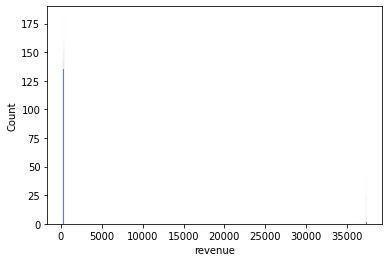

In [40]:
sns.histplot(data=dfta.query('revenue>0'), x='revenue')

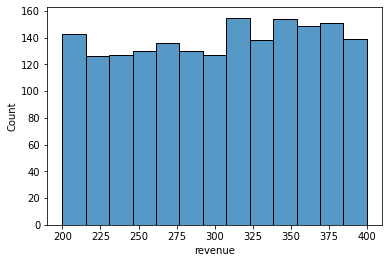

In [41]:
sns.histplot(data=dfta.query('revenue>0 and revenue<35000'), x='revenue')

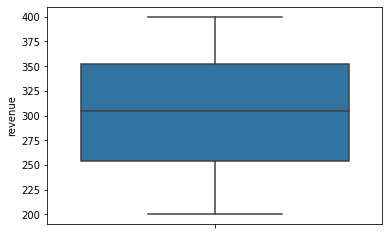

In [42]:
sns.boxplot(data=dfta.query('revenue>0 and revenue<35000'), y='revenue')

In [43]:
dfta.query('revenue>35000').revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

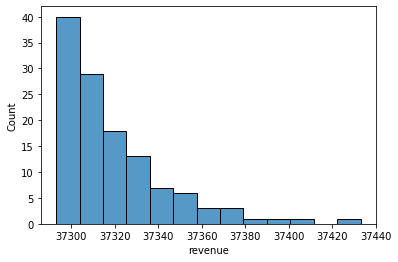

In [44]:
sns.histplot(data=dfta.query('revenue>35000'), x='revenue')

Можно отметить, что 123 пользователя ("киты") заплатили существенно больше (на 37000), чем остальные. Это может быть связано с покупкой некоего дорогостоящего артефакта либо с ошибкой в данных, т.к. смещение от основной массы фиксированное (в нашем случае может быть объяснено синтетическим происхождением датасета). Также размер этой группы совпадает с дельтой, на которую уменьшилась тестовая, что позволяет сделать вывод о том, что во второй группе "киты отвалились".

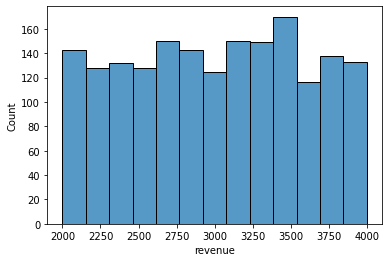

In [45]:
sns.histplot(data=dftb.query('revenue>0'), x='revenue')

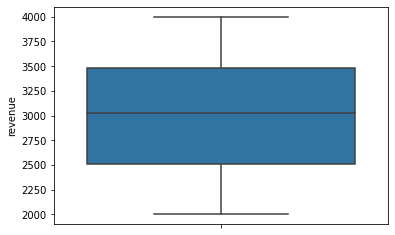

In [46]:
sns.boxplot(data=dftb.query('revenue>0'), y='revenue')

Вторая группа однородная.

## 2.2.&nbsp;Выбор и расчёт метрик

### 2.2.1.&nbsp;ARPU

Рассчитаем средний доход на пользователя.

In [47]:
dfta.revenue.mean()

25.413719736965806

In [48]:
dftb.revenue.mean()

26.75128659327863

In [49]:
results['ARPU']['a'] = dfta.revenue.mean()
results['ARPU']['b'] = dftb.revenue.mean()

ARPU увеличилось, но несущественно, далее проверим на статзначимость.

### 2.2.2.&nbsp;ARPPU

Посчитаем отдельно для платящих пользователе.

In [50]:
dfta.query('revenue>0').revenue.mean()

2663.9984439834025

In [51]:
dftb.query('revenue>0').revenue.mean()

3003.6581717451522

In [52]:
results['ARPPU']['a'] = dfta.query('revenue>0').revenue.mean()
results['ARPPU']['b'] = dftb.query('revenue>0').revenue.mean()

In [53]:
results

,users,paid,CR,ARPU,ARPPU,sum
a,202103,1928,NaN,25.4137,2664,NaN
b,202667,1805,NaN,26.7513,3003.66,NaN


ARPPU также выросло.

### 2.2.3.&nbsp;CR

Посмотрим, что с конверсией.

In [54]:
cr_a = len(dfta.query('revenue>0').index) / len(dfta.index) * 100
cr_a

0.9539690157988748

In [55]:
cr_b = len(dftb.query('revenue>0').index) / len(dftb.index) * 100
cr_b

0.8906235351586593

In [56]:
(cr_b - cr_a) / cr_a * 100

-6.6402031503264904

In [57]:
len(dfta.query('revenue==0').index)

200175

In [58]:
len(dftb.query('revenue==0').index)

200862

In [59]:
results['CR']['a'] = cr_a
results['CR']['b'] = cr_b

In [60]:
results['sum']['a'] = dfta.revenue.sum()
results['sum']['b'] = dftb.revenue.sum()

Конверсия уменьшилась на 6.6%.

## 2.3.&nbsp;Проверка гипотез

По гистограммам распределения в группах далеки от нормального, проверим тестами.

In [61]:
pg.normality(dfta.revenue, method="normaltest")

,W,pval,normal
revenue,585152.731273,0.0,False


In [62]:
pg.normality(dftb.revenue, method="normaltest")

,W,pval,normal
revenue,326622.395409,0.0,False


Распределения не относятся к нормальному.

In [63]:
pg.homoscedasticity(data=dftest, dv='revenue', group='testgroup')

,W,pval,equal_var
levene,0.389629,0.532495,True


In [64]:
pg.homoscedasticity(data=dftest, dv='revenue', group='testgroup', method='bartlett')

,T,pval,equal_var
bartlett,228631.095336,0.0,False


Тест Левена показывает равенство дисперсий, а Бартлетта нет. Учитывая это и большое количество наблюдений попробуем помимо непараметрического теста Манна-Уитни воспользоваться обычным тестом Стьюдента.

### 2.3.1.&nbsp;ARPU

Нулевая гипотеза - ARPU одинаковы, альтернативная - различие статистически значимо.

In [65]:
sps.mannwhitneyu(dfta.revenue.values, dftb.revenue.values)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [66]:
pg.ttest(dfta.revenue.values, dftb.revenue.values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Тест Манна-Уитни не прокрасился, хотя и был близок к критическому значению. Тест Стьюдента также не показал статистической значимости.

### 2.3.2.&nbsp;ARPPU

In [67]:
sps.mannwhitneyu(dfta.query('revenue>0').revenue.values, dftb.query('revenue>0').revenue.values)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

In [68]:
pg.ttest(dfta.query('revenue>0').revenue.values, dftb.query('revenue>0').revenue.values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


Тест Манна-Уитни показал, что различие в ARPPU (фактически в средних значениях, но они всё равно идут в формулу ARPPU) статистически значимо. Тест Стьюдента дал отрицательный результат, но величина статистики близка к критическому уровню.

### 2.3.3.&nbsp;CR

Значимость различий в конверсии проверим с использованием критерия Хи-квадрат. Для этого добавим столбец платил пользователь или нет.

In [69]:
dftest['paid'] = np.where(dftest.revenue>0, 'yes', 'no')
dftest.head()

,user_id,revenue,testgroup,paid
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no


In [70]:
expected, observed, stats = pg.chi2_independence(dftest, x='testgroup', y='paid')

In [71]:
expected

paid,no,yes
testgroup,,
a,200239.100751,1863.899249
b,200797.899249,1869.100751


In [72]:
observed

paid,no,yes
testgroup,,
a,200175.5,1927.5
b,200861.5,1805.5


In [73]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


Различия в конверсии носят статистически значимый характер.

## 2.4.&nbsp;Выводы

In [74]:
print('Paid users percent change:', round((results['paid']['b'] - results['paid']['a']) / results['paid']['a'] * 100, 1))
print('CR percent change:', round((results['CR']['b'] - results['CR']['a']) / results['CR']['a'] * 100, 1))
print('ARPU percent change:', round((results['ARPU']['b'] - results['ARPU']['a']) / results['ARPU']['a'] * 100, 1))
print('ARPPU percent change:', round((results['ARPPU']['b'] - results['ARPPU']['a']) / results['ARPPU']['a'] * 100, 1))
print('Total revenue percent change:', round((results['sum']['b'] - results['sum']['a']) / results['sum']['a'] * 100, 1))

Paid users percent change: -6.4
CR percent change: -6.6
ARPU percent change: 5.3
ARPPU percent change: 12.7
Total revenue percent change: 5.6


In [75]:
results.style.set_caption('Метрики контрольной и тестовой групп').format("{:.2f}", subset=['CR', 'ARPU', 'ARPPU'])

,users,paid,CR,ARPU,ARPPU,sum
a,202103,1928,0.95,25.41,2664.00,5136189
b,202667,1805,0.89,26.75,3003.66,5421603


Несмотря на то, что количество платящих пользователей и конверсия снизились (на 6.4 и 6.6 процентов соответственно), метрики прибыли выросли: ARPU на 5.3%, ARPPU на 12.7%, суммарный доход на 5.6%. Изменения CR и ARPPU носят статистически значимый характер.

В то же время стоит отметить, что группа в 123 пользователя совершавших большие покупки в контрольной группе исчезла из тестовой. Для оценки значимости этого необходимы дополнительные данные о целевых показателях и стратегии работы с аудиторией.

В целом считаю допустимым распространить новые акционные предложения на всех пользователей, уделив отдельное внимание "китам".

# 3.&nbsp;Выбор метрик для оценки игровых событий

Первое, с чего бы я начал: сколько игроков получили награду (выполнили все требования события) - конверсия. Также можно посчитать конверсию из начавших участвовавших в событии в успешно завершивших его. Это позволит оценить, насколько наше событие привлекло игроков, было ли оно массовым или прошло незамеченным.

Затем можно посчитать общие показатели пользовательской активности: installs, retention, churn rate, DAU и т.д. Это даст оценку того, как событийная активность сказалась на общем притоке/оттоке пользователей, привлечены ли новые, вернулись ли старые.

С точки зрения геймдизайна было бы полезно проанализировать статистику по уровням и времени их прохождения, повлияло ли введение дополнительных наград на метрики прохождения уровней.

Наконец прибыль: вырос ли общий доход в результате события; ARPU, ARPPU - общие и с разбивкой на когорты, например участвовавшие в ивенте и остальные.

Если усложнить механику и откатывать игрока назад на несколько уровней в случае неудачи, то метрики останутся в основном те же самые. Но необходимо будет внимательно контролировать вовлечённость игроков (не упала ли), churn rate, статистику прохождения уровней (количество попыток, время прохождения и т.д.). Также можно отслеживать показатели прибыли: будет ли усложнение игры стимулировать пользователей покупать "плюшки" для облегчения или нет.